# CPSC 330 hw7

In [1]:
import numpy as np
import pandas as pd

In [4]:
### BEGIN SOLUTION
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import r2_score
### END SOLUTION

## Instructions
rubric={points:5}

Follow the [homework submission instructions](https://github.students.cs.ubc.ca/cpsc330-2019w-t2/home/blob/master/docs/homework_instructions.md). 

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. As usual, please do not commit it to your repos.

In [5]:
df = pd.read_csv("avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [6]:
df.shape

(18249, 13)

In [7]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [8]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [9]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [10]:
assert len(df_train) + len(df_test) == len(df)

#### 1(a)
rubric={points:3}

In the Rain is Australia dataset from Lecture 16, we had different measurements for each Location. What about this dataset: for which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

### BEGIN SOLUTION

In [11]:
df.sort_values(by="Date").head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


From the above, we definitely see measurements on the same day at different regresion. Let's now group by region.

In [12]:
df.sort_values(by=["region", "Date"]).head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
51,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
50,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
50,2015-01-11,1.77,1182.56,39.00,305.12,0.00,838.44,838.44,0.00,0.0,organic,2015,Albany
49,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany


From the above we see that, even in Albany, we have two measurements on the same date. This seems to be due to the type of avocado.

In [13]:
df.sort_values(by=["region", "type", "Date"]).head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
50,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
49,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
48,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
47,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany


Great, now we have a sequence of dates with a single row per date. So, the answer is that we have a separate timeseries for each combination of `region` and `type`.

### END SOLUTION

#### 1(b)
rubric={points:3}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

### BEGIN SOLUTION

I think it's not unreasonable to do this on `df` rather than `df_train`, but either way is fine. 

In [14]:
for name, group in df.groupby(['region', 'type']):
    print("%-40s %s" % (name, group["Date"].sort_values().diff().min()))

('Albany', 'conventional')               7 days 00:00:00
('Albany', 'organic')                    7 days 00:00:00
('Atlanta', 'conventional')              7 days 00:00:00
('Atlanta', 'organic')                   7 days 00:00:00
('BaltimoreWashington', 'conventional')  7 days 00:00:00
('BaltimoreWashington', 'organic')       7 days 00:00:00
('Boise', 'conventional')                7 days 00:00:00
('Boise', 'organic')                     7 days 00:00:00
('Boston', 'conventional')               7 days 00:00:00
('Boston', 'organic')                    7 days 00:00:00
('BuffaloRochester', 'conventional')     7 days 00:00:00
('BuffaloRochester', 'organic')          7 days 00:00:00
('California', 'conventional')           7 days 00:00:00
('California', 'organic')                7 days 00:00:00
('Charlotte', 'conventional')            7 days 00:00:00
('Charlotte', 'organic')                 7 days 00:00:00
('Chicago', 'conventional')              7 days 00:00:00
('Chicago', 'organic')         

In [15]:
for name, group in df.groupby(['region', 'type']):
    print("%-40s %s" % (name, group["Date"].sort_values().diff().max()))

('Albany', 'conventional')               7 days 00:00:00
('Albany', 'organic')                    7 days 00:00:00
('Atlanta', 'conventional')              7 days 00:00:00
('Atlanta', 'organic')                   7 days 00:00:00
('BaltimoreWashington', 'conventional')  7 days 00:00:00
('BaltimoreWashington', 'organic')       7 days 00:00:00
('Boise', 'conventional')                7 days 00:00:00
('Boise', 'organic')                     7 days 00:00:00
('Boston', 'conventional')               7 days 00:00:00
('Boston', 'organic')                    7 days 00:00:00
('BuffaloRochester', 'conventional')     7 days 00:00:00
('BuffaloRochester', 'organic')          7 days 00:00:00
('California', 'conventional')           7 days 00:00:00
('California', 'organic')                7 days 00:00:00
('Charlotte', 'conventional')            7 days 00:00:00
('Charlotte', 'organic')                 7 days 00:00:00
('Chicago', 'conventional')              7 days 00:00:00
('Chicago', 'organic')         

It looks almost perfect - just organic avocados in WestTexNewMexico seems to be missing a couple measurements.

In [16]:
name

('WestTexNewMexico', 'organic')

In [17]:
group["Date"].sort_values().diff().value_counts()

7 days     163
21 days      1
14 days      1
Name: Date, dtype: int64

So, in one case there's a 2-week jump, and in one cast there's a 3-week jump.

In [18]:
group["Date"].sort_values().reset_index(drop=True).diff().sort_values()

1      7 days
106    7 days
107    7 days
108    7 days
109    7 days
        ...  
52     7 days
165    7 days
48    14 days
127   21 days
0         NaT
Name: Date, Length: 166, dtype: timedelta64[ns]

We can see the anomalies occur at index 48 and 127. (Note: I had to `reset_index` because the index was not unique to each row.)

In [19]:
group["Date"].sort_values().reset_index(drop=True)[45:50]

45   2015-11-15
46   2015-11-22
47   2015-11-29
48   2015-12-13
49   2015-12-20
Name: Date, dtype: datetime64[ns]

We can spot the first anomaly: a 2-week jump from Nov 29, 2015 to Dec 13, 2015.

In [20]:
group["Date"].sort_values().reset_index(drop=True)[125:130]

125   2017-06-04
126   2017-06-11
127   2017-07-02
128   2017-07-09
129   2017-07-16
Name: Date, dtype: datetime64[ns]

And we can spot the second anomaly: a 3-week jump from June 11, 2017 to July 2, 2017.

### END SOLUTION

#### 1(c)
rubric={points:1}

In the Rain is Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

### BEGIN SOLUTION

In [21]:
df["region"].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

There seems to be a hierarchical structure here: `TotalUS` is split into bigger regions like `West`, `Southeast`, `Northeast`, `Midsouth`; and `California` is split into cities like `Sacramento`, `SanDiego`, `LosAngeles`. It's a bit hard to figure out what's going on.

In [20]:
df.query("region == 'TotalUS' and type == 'conventional' and Date == '20150104'")["Total Volume"].values[0]

31324277.73

In [21]:
df.query("region != 'TotalUS' and type == 'conventional' and Date == '20150104'")["Total Volume"].sum()

51730521.73

Since the individual regions sum up to more than the total US, it seems that some of the other regions are double-counted, which is consistent with a hierarchical structure. For example, Los Angeles is probalby double counted because it's within `LosAngeles` but also within `California`. What a mess!

### END SOLUTION

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price, which is the `AveragePrice` column. The function below is adapted from Lecture 16, with some improvements.

In [22]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [23]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [24]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


I will now split the data:

In [25]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

#### 1(d)
rubric={points:1}

Why was it reasonable for me to do this operation _before_ splitting the data, despite the fact that this usually constitutes a violation of the Golden Rule?

### BEGIN SOLUTION

Because we were only looking at the dates and creating the future feature. The difference is that the very last time point in our training set now contains the average price from the first time point in our test set. This is a realistic scenario if we wre actually using this model to forecast, so it's not a major concern.

### END SOLUTION

#### 1(e)
rubric={points:1}

Next we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML, let's try a baseline: just predicting the previous week's `AveragePrice`. What $R^2$ do you get with this approach?

### BEGIN SOLUTION

In [26]:
r2_score(df_train["AveragePriceNextWeek"], df_train["AveragePrice"])

0.8285800937261841

In [27]:
r2_score(df_test["AveragePriceNextWeek"], df_test["AveragePrice"])

0.7631780188583048

Interesting that this is a less effective prediction strategy in the later part of the dataset. I guess that means the price was fluctuating more in late 2017 / early 2018?

### END SOLUTION

#### 1(f)
rubric={points:10}

Build some models to forecast the average avocado price. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

### BEGIN SOLUTION

In [28]:
df_train.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99


In [29]:
(df_train.loc[:, "Small Bags": "XLarge Bags"].sum(axis=1) - df_train["Total Bags"]).abs().max()

1.0

It seems that `Total Bags` is (approximately) the sum of the other 3 bag features, so I will drop `Total Bags`.

In [30]:
(df_train.loc[:, "4046": "4770"].sum(axis=1) - df_train["Total Volume"]).abs().max()

16298296.29

It seems that `Total Volume` is _not_ the sum of the 3 avocado types, so I will keep all 4 columns.

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15441 entries, 0 to 18222
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  15441 non-null  datetime64[ns]
 1   AveragePrice          15441 non-null  float64       
 2   Total Volume          15441 non-null  float64       
 3   4046                  15441 non-null  float64       
 4   4225                  15441 non-null  float64       
 5   4770                  15441 non-null  float64       
 6   Total Bags            15441 non-null  float64       
 7   Small Bags            15441 non-null  float64       
 8   Large Bags            15441 non-null  float64       
 9   XLarge Bags           15441 non-null  float64       
 10  type                  15441 non-null  object        
 11  year                  15441 non-null  int64         
 12  region                15441 non-null  object        
 13  AveragePriceNext

It seems there are no null values, so I will not do any imputation.

Will plot a single time series for exploration purposes:

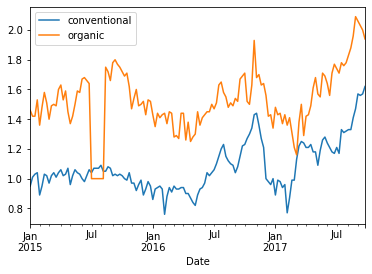

In [32]:
df_train.query("region == 'TotalUS'").set_index("Date").groupby("type")["AveragePrice"].plot(legend=True);

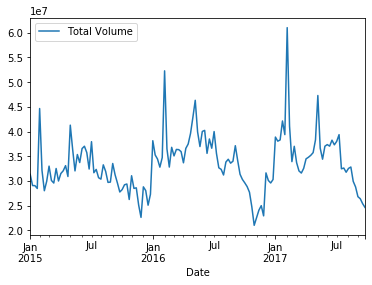

In [33]:
df_train.query("region == 'TotalUS' and type == 'conventional'").plot(x="Date", y="Total Volume");

We see some seasonality in the total volume, but not much in the average price - interesting.

I will not scale the `AveragePrice` because I am not scaling `AveragePriceNextWeek` either, and it may be helpful to keep them the same. Alternatively, it may have been effective to predict the _change_ in price instead of next's week's price.

In [34]:
numeric_features     = ["Total Volume", "4046", "4225", "4770", "Small Bags", "Large Bags", "XLarge Bags", "year"]
categorical_features = ["type", "region"]
keep_features        = ["AveragePrice"]
drop_features        = ["Date", "Total Bags"] 
target_feature       = "AveragePriceNextWeek"

Next, I grab the `preprocess_features` function from Lecture 16, with a minor modification to allow un-transformed features via `keep_features`:

In [35]:
def preprocess_features(df_train, df_test, 
                        numeric_features, 
                        categorical_features, 
                        keep_features, 
                        drop_features, 
                        target_feature):
    
    all_features = numeric_features + categorical_features + keep_features + drop_features + [target_feature]
    if set(df_train.columns) != set(all_features):
        print("Missing columns", set(df_train.columns) - set(all_features))
        print("Extra columns", set(all_features) - set(df_train.columns))
        raise Exception("Columns do not match")
        
    # Put the columns in the order we want
    df_train = df_train[all_features]
    df_test = df_test[all_features]
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(sparse=False, drop='first'))
    ])
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ], remainder='passthrough')
    preprocessor.fit(df_train);

    if len(categorical_features) > 0:
        ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
        ohe_feature_names = list(ohe.get_feature_names(categorical_features))
        new_columns = numeric_features + ohe_feature_names + keep_features + drop_features + [target_feature]
    else:
        new_columns = all_features

    X_train_enc = pd.DataFrame(preprocessor.transform(df_train), index=df_train.index, columns=new_columns)
    X_test_enc  = pd.DataFrame(preprocessor.transform(df_test),  index=df_test.index,  columns=new_columns)
    
    X_train_enc = X_train_enc.drop(columns=drop_features + [target_feature])
    X_test_enc  = X_test_enc.drop( columns=drop_features + [target_feature])
    
    y_train = df_train[target_feature]
    y_test  = df_test[ target_feature]
    
    return X_train_enc, y_train, X_test_enc, y_test

In [36]:
df_train_enc, y_train, df_test_enc, y_test = preprocess_features(df_train, df_test, 
                        numeric_features, 
                        categorical_features, 
                        keep_features, 
                        drop_features, 
                        target_feature)

In [37]:
df_train_enc.head()

,Total Volume,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,year,type_organic,region_Atlanta,...,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico,AveragePrice
0,-0.234535,-0.229503,-0.222203,-0.214954,-0.229907,-0.223154,-0.172063,-1.14705,0,0,...,0,0,0,0,0,0,0,0,0,1.22
1,-0.23444,-0.230948,-0.219448,-0.214272,-0.231513,-0.223789,-0.172063,-1.14705,0,0,...,0,0,0,0,0,0,0,0,0,1.24
2,-0.233469,-0.231018,-0.21953,-0.214196,-0.226469,-0.224325,-0.172063,-1.14705,0,0,...,0,0,0,0,0,0,0,0,0,1.17
3,-0.233283,-0.230996,-0.21817,-0.213945,-0.228629,-0.222193,-0.172063,-1.14705,0,0,...,0,0,0,0,0,0,0,0,0,1.06
4,-0.225747,-0.230668,-0.196131,-0.213811,-0.22993,-0.224856,-0.172063,-1.14705,0,0,...,0,0,0,0,0,0,0,0,0,0.99


In [38]:
lr = Ridge()
lr.fit(df_train_enc, y_train);

In [39]:
lr.score(df_train_enc, y_train)

0.8451121096743694

In [40]:
lr.score(df_test_enc, y_test)

0.7879252704467005

In [41]:
lr_coef = pd.DataFrame(data=np.squeeze(lr.coef_), index=df_train_enc.columns, columns=["Coef"])
lr_coef.sort_values(by="Coef", ascending=False)

,Coef
AveragePrice,0.802224
type_organic,0.099166
region_SanFrancisco,0.060399
region_HartfordSpringfield,0.057964
region_NewYork,0.040027
...,...
region_CincinnatiDayton,-0.071877
region_Denver,-0.073122
region_SouthCentral,-0.093012
region_DallasFtWorth,-0.093052


This is not a very impressive showing. We're doing almost the same as the baseline.

Let's see if encoding the date helps at all. We'll try to OHE the month.

In [42]:
df_train_month = df_train.assign(Month=df_train["Date"].apply(lambda x: x.month))
df_test_month  = df_test.assign( Month=df_test[ "Date"].apply(lambda x: x.month))

In [43]:
df_train_month_enc, y_train, df_test_month_enc, y_test = preprocess_features(df_train_month, df_test_month, 
                        numeric_features, 
                        categorical_features + ["Month"], 
                        keep_features, 
                        drop_features, 
                        target_feature)

In [44]:
df_train_month_enc.head()

,Total Volume,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,year,type_organic,region_Atlanta,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,AveragePrice
0,-0.234535,-0.229503,-0.222203,-0.214954,-0.229907,-0.223154,-0.172063,-1.14705,0,0,...,0,0,0,0,0,0,0,0,0,1.22
1,-0.23444,-0.230948,-0.219448,-0.214272,-0.231513,-0.223789,-0.172063,-1.14705,0,0,...,0,0,0,0,0,0,0,0,0,1.24
2,-0.233469,-0.231018,-0.21953,-0.214196,-0.226469,-0.224325,-0.172063,-1.14705,0,0,...,0,0,0,0,0,0,0,0,0,1.17
3,-0.233283,-0.230996,-0.21817,-0.213945,-0.228629,-0.222193,-0.172063,-1.14705,0,0,...,0,0,0,0,0,0,0,0,0,1.06
4,-0.225747,-0.230668,-0.196131,-0.213811,-0.22993,-0.224856,-0.172063,-1.14705,0,0,...,0,0,0,0,0,0,0,0,0,0.99


In [45]:
lr = Ridge()
lr.fit(df_train_month_enc, y_train);

In [46]:
lr.score(df_train_month_enc, y_train)

0.8493646825546322

In [47]:
lr.score(df_test_month_enc, y_test)

0.8001293268972669

A tiny bit better.

In [48]:
pd.DataFrame(data=np.squeeze(lr.coef_), index=df_train_month_enc.columns, columns=["Coef"]).sort_values(by="Coef", ascending=False)

,Coef
AveragePrice,0.771853
type_organic,0.114584
Month_9,0.098114
Month_8,0.081332
Month_7,0.069596
...,...
region_CincinnatiDayton,-0.083448
region_Denver,-0.084731
region_SouthCentral,-0.106716
region_DallasFtWorth,-0.107661


Let's add some lag features. I'm arbitrarily deciding on 4 lags for `AveragePrice` (the most important feature).

In [49]:
def add_lags(df):
    df = create_lag_feature(df, "AveragePrice", -1, ["region", "type"])
    df = create_lag_feature(df, "AveragePrice", -2, ["region", "type"])
    df = create_lag_feature(df, "AveragePrice", -3, ["region", "type"])
    df = create_lag_feature(df, "AveragePrice", -4, ["region", "type"])
    return df

df_train_month_lag = add_lags(df_train_month)
df_test_month_lag  = add_lags(df_test_month)

In [50]:
df_train_month_lag

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,Month,AveragePrice_lag1,AveragePrice_lag2,AveragePrice_lag3,AveragePrice_lag4
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24,1,NaN,NaN,NaN,NaN
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17,1,1.22,NaN,NaN,NaN
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06,1,1.24,1.22,NaN,NaN
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99,1,1.17,1.24,1.22,NaN
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99,2,1.06,1.17,1.24,1.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218,2017-08-27,2.50,16137.93,2616.96,3672.96,0.00,9848.01,9816.58,31.43,0.0,organic,2017,WestTexNewMexico,2.39,8,2.43,2.01,1.78,1.67
18219,2017-09-03,2.39,7657.47,927.27,4056.73,0.00,2673.47,2629.18,44.29,0.0,organic,2017,WestTexNewMexico,2.38,9,2.50,2.43,2.01,1.78
18220,2017-09-10,2.38,11857.31,1562.10,4565.41,0.00,5729.80,5719.96,9.84,0.0,organic,2017,WestTexNewMexico,2.36,9,2.39,2.50,2.43,2.01
18221,2017-09-17,2.36,10464.29,1845.14,2819.17,0.00,5799.98,5796.65,3.33,0.0,organic,2017,WestTexNewMexico,2.26,9,2.38,2.39,2.50,2.43


In [51]:
df_train_month_lag_enc, y_train, df_test_month_lag_enc, y_test = preprocess_features(df_train_month_lag, df_test_month_lag, 
                        numeric_features + ["AveragePrice_lag1", "AveragePrice_lag2", "AveragePrice_lag3", "AveragePrice_lag4"], 
                        categorical_features + ["Month"], 
                        keep_features, 
                        drop_features, 
                        target_feature)

In [52]:
lr = Ridge()
lr.fit(df_train_month_lag_enc, y_train);

In [53]:
lr.score(df_train_month_lag_enc, y_train)

0.8595737220705675

In [54]:
lr.score(df_test_month_lag_enc, y_test)

0.799928400814506

This did not seem to help.

In [55]:
pd.DataFrame(data=np.squeeze(lr.coef_), index=df_train_month_lag_enc.columns, columns=["Coef"]).sort_values(by="Coef", ascending=False)

,Coef
AveragePrice,0.578971
Month_9,0.080655
type_organic,0.068920
Month_8,0.068412
Month_7,0.062242
...,...
region_CincinnatiDayton,-0.046909
region_Denver,-0.049935
region_SouthCentral,-0.061838
region_DallasFtWorth,-0.063216


We can also try a random forest:

In [56]:
rf = RandomForestRegressor() 
rf.fit(df_train_month_lag_enc, y_train);

In [57]:
rf.score(df_train_month_lag_enc, y_train)

0.9803473750084566

In [58]:
rf.score(df_test_month_lag_enc, y_test)

0.7881576575449211

For the random forest it may be helpful to model the difference between today and tomorrow. The linear model does not care about this because it just corresponds to changing the coefficient corresponding to `AveragePrice` by 1, but for the random forest it may help:

In [59]:
rf = RandomForestRegressor() 
rf.fit(df_train_month_lag_enc, y_train - df_train_month_lag_enc["AveragePrice"]);

In [60]:
r2_score(y_train, rf.predict(df_train_month_lag_enc) + df_train_month_lag_enc["AveragePrice"])

0.9811141458611501

In [61]:
r2_score(y_test, rf.predict(df_test_month_lag_enc) + df_test_month_lag_enc["AveragePrice"])

0.7930794327755512

This massively overfits when we do this shifting. Let's try a simpler model...

In [62]:
rf = RandomForestRegressor(max_depth=8) 
rf.fit(df_train_month_lag_enc, y_train - df_train_month_lag_enc["AveragePrice"]);

In [63]:
r2_score(y_train, rf.predict(df_train_month_lag_enc) + df_train_month_lag_enc["AveragePrice"])

0.8806745967148035

In [64]:
r2_score(y_test, rf.predict(df_test_month_lag_enc) + df_test_month_lag_enc["AveragePrice"])

0.7918540090920355

Doesn't realy help.

Also, we can just confirm that this shifting has no effect on the linear model (well, a small effect because it's `Ridge` instead of `LinearRegression`, but small):

In [65]:
lr = Ridge() 
lr.fit(df_train_month_lag_enc, y_train - df_train_month_lag_enc["AveragePrice"]);

In [66]:
r2_score(y_train, lr.predict(df_train_month_lag_enc) + df_train_month_lag_enc["AveragePrice"])

0.8595736988337311

In [67]:
r2_score(y_test, lr.predict(df_test_month_lag_enc) + df_test_month_lag_enc["AveragePrice"])

0.8000721542721965

Indeed, this is essentially the same score we had before.

Overall, adding the month helped, but adding the lagged price was surprisingly unhelpful. Perhaps lagged version of other features would have been better, or other representations of the time of year, or dealing with the regions and avocado types a bit more carefully. 

### END SOLUTION

#### 1(g)
rubric={points:3}

We talked a little bit about _seasonality_, which is the idea of a periodic component to the time series. For example, in Lecture 16 we attempted to capture this by encoding the month. Something we didn't discuss is _trends_, which are long-term variations in the quantity of interest. Aside from the effects of climate change, the amount of rain in Australia is likely to vary during the year but less likely to have long-term trends over the years. Avocado prices, on the other hand, could easily exhibit trends: for example avocados may just cost more in 2020 than they did in 2015.

Briefly discuss in ~1 paragraph: to what extent, if any, was your model above able to account for seasonality? What about trends?

### BEGIN SOLUTION

I tried to take seasonality into account by having the month as an OHE variable. As far as trends are concerned, the year is also a numeric variable in the model, so it could learn that the price in 2017 is higher than in 2015, say. However, there are very few years in the training set (2015, 16, 17), so that is not a lot of data to learn from. Perhaps including the number of months since the start of the dataset, or something like that, would enable the model to do a bit better with trends. Nonetheless, extrapolating is very hard so we can't necessarily trust our models' handing of trend. 



In [68]:
pd.DataFrame(data=np.squeeze(lr.coef_), index=df_train_month_lag_enc.columns, columns=["Coef"]).loc["year"]

Coef    0.013409
Name: year, dtype: float64

It seems that our linear model learned a small positive trend for the year. It would be cool to use SHAP and see what the random forest is doing.

### END SOLUTION

## Exercise 2: very short answer questions

Each question is worth 2 points.

#### 2(a)
rubric={points:4}

The following questions pertain to Lecture 16 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

### BEGIN SOLUTION

1. Many many examples: credit card transactions, log files, basically any situation where the frequency of the measurements could not be chosen by the person taking the measurements. 
2. Encoding the date as, e.g. OHE month works just fine with unequally spaced points. However, the lag features are more problematic, because the "previous" measurement will be a different length of time away in each case. 

### END SOLUTION

#### 2(b)
rubric={points:10}

The following questions pertain to Lecture 17 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques, as we did in hw4?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer? (This is a bit tricky - it's OK if you don't know the answer, but try to argue your case.)
3. One of the true/false questions from class was: "If a customer is censored after 5 months with the service, then all customers are censored after 5 months (i.e. no values of `tenure` above 5)." What is the answer if all customers joined the service at the same time? Briefly explain.
4. One of the true/false questions from class was: "If a customer is censored after 5 months with the service, then all customers are censored after 5 months (i.e. no values of `tenure` above 5)." What is the answer if customers did not necessarily join the service at the same time? Briefly explain.
5. If a customer's survival function is almost flat during a certain period, how do we interpret that?

### BEGIN SOLUTION

1. The "not churned" are censored - we don't know if they will churn shortly or in a long time. These people have the same label and our model will be impacted negatively.
2. Not enough information - it depends! Imagine a subscription service where you have to pay a starter fee after a month and then pay a huge fee after a year. Well, customer B just paid that huge fee and will probably stay a while, whereas customer A may leave before paying the huge fee, so customer A will probably leave first. But imagine a service where people are more and more likely to leave every day, e.g. a movie service with only 100 movies, so you can run out easily. In that case customer B will probably leave first.
3. True. If all started at the same time, and a customer is censored after 5 months, that means they all started 5 months ago and are all censored after 5 months.
4. False. That particular customer started 5 months ago, but you may have another customer who started much longer ago.
5. The customer is very unlikely to leave during that period.

### END SOLUTION

#### 2(c)
rubric={points:10}

The following questions pertain to Lecture 18 on clustering.

1. What's the main difference between unsupervised and supervised learning?
2. When choosing $k$ in $k$-means, why not just choose the $k$ that leads to the smallest inertia (sum of squared distances within clusters)?
3. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with $k$-means?
4. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with DBSCAN?
5. For hierarchical clustering, we briefly discussed a few different methods for merging clusters: single linkage, average linkage, etc. Why do we have this added complication here - can't we just minimize distance like we did with $k$-means? 

### BEGIN SOLUTION

1. Supervised has target values ($y$), unsupervised does not.
2. Because inertia decreases with $k$, so you'd just choose $k=n$, which is not interesting.
3. Look for examples that are very far away from their cluster mean.
4. Look for examples that were not assigned to any cluster.
5. With $k$-means we had to find the distance between a point and a cluster mean. Here, we need to find the distance between two clusters, and, importantly, we have no cluster means. So it's ambiguous how to definite distance between two clusters.

### END SOLUTION